## The Darcy's equation

We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Fourier Neural Operator method

### (2.1) Prepare data

<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
<KeysViewHDF5 ['X', 'Y', 'beta1', 'beta2', 'coeff', 'sol', 'soldx', 'soldy']>
The shape of ax_train: torch.Size([1000, 29, 29, 3])
The shape of u_train: torch.Size([1000, 29, 29, 1])
The shape of gridx_train: torch.Size([841, 2])
The shape of beta1 torch.Size([1000, 1]) The shape of beta2 torch.Size([1000, 1])
The shape of ax_test: torch.Size([200, 29, 29, 3])
The shape of u_test: torch.Size([200, 29, 29, 1])
The shape of gridx_test: torch.Size([841, 2])
The shape of beta1 torch.Size([200, 1]) The shape of beta2 torch.Size([200, 1])


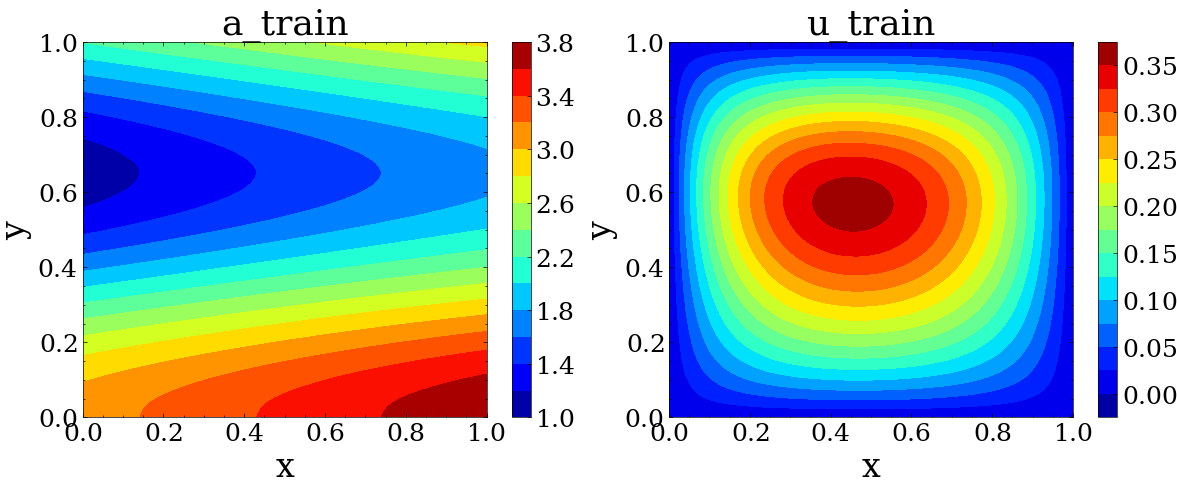

In [4]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'DarcyFlow_smh'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/smh_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/smh_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
#
def get_data(data, ndata, res, res_coe=29, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["sol"][...,n0:n0+ndata]).T, dtype)
    beta1 = np2tensor(np.array(data["beta1"][n0:n0+ndata]), dtype)
    beta2 = np2tensor(np.array(data["beta2"][n0:n0+ndata]), dtype)
    #
    X, Y = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(1, res, res, 2)
    #
    try:
        X_coe, Y_coe = np.array(data['X_coe']).T, np.array(data['Y_coe']).T
    except:
        X_coe, Y_coe = np.array(data['X']).T, np.array(data['Y']).T
    mesh = np2tensor(np.vstack([X_coe.ravel(), Y_coe.ravel()]).T, dtype)
    gridx_coe = mesh.reshape(1, res_coe, res_coe, 2)
    ax = torch.cat([a.reshape(ndata, res_coe, res_coe,1), gridx_coe.repeat(ndata, 1, 1, 1)], dim=-1)
    #
    u = u.reshape(ndata, res, res, 1)
    
    return ax, u, gridx.reshape(-1,2), beta1, beta2
#
ax_train, u_train, gridx_train, beta1_train, beta2_train = get_data(data_train, n_train, res=29)
ax_test, u_test, gridx_test, beta1_test, beta2_test = get_data(data_test, n_test, res=29)
#
print('The shape of ax_train:', ax_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('The shape of beta1', beta1_train.shape, 'The shape of beta2', beta2_train.shape)
print('The shape of ax_test:', ax_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
print('The shape of beta1', beta1_test.shape, 'The shape of beta2', beta2_test.shape)

### (2.2) Define the loss class

In [5]:
###############################
# Set normalizer
###############################
from Utils.Normalizer import *
normalizer_ax = UnitGaussianNormalizer(ax_train.to(device))
normalizer_u = UnitGaussianNormalizer(u_train.to(device))

###############################
# Define Loss Class
###############################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']

    def Loss_data(self, ax, u):
        ''' '''
        ax_norm = normalizer_ax.encode(ax)
        u_pred_norm = self.model_u(ax_norm)
        #
        try: # When ax_test and u_test share the same meshgrids
            u_norm = normalizer_u.encode(u)
            return self.solver.getLoss(u_pred_norm, u_norm)
        except:
            return torch.tensor(0.)
        
        return loss

    def Error(self, ax, u):
        ''' '''
        ax_norm = normalizer_ax.encode(ax)
        u_pred_norm = self.model_u(ax_norm)
        #
        try: # When ax_test and u_test share the same meshgrids
            u_norm = normalizer_u.encode(u)
            return self.solver.getError(u_pred_norm, u_norm)
        except:
            return torch.tensor(0.)
            
######################################
# Steups of the model and training 
######################################
from Solvers.FNO import FNO
solver = FNO.Solver(device, dtype)
netType = 'FNO2d'
model_u = solver.getModel(in_size=3, out_size=1, modes=[12, 12], hidden_list=[64]*4, 
                          activation='ReLU', netType='FNO2d') 

### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
# Train the model
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', step_size=100)
solver.train(LossClass, ax_train, u_train, ax_test, u_test, 
             batch_size=50, epochs=1000,  epoch_show=100,
             **{'save_path':f'saved_models/{netType}/'})

 10%|███████▉                                                                       | 101/1000 [00:17<02:20,  6.40it/s]

Epoch:100 Time:17.2267, loss_train:0.558411, loss_test:0.780255
          lr: 0.0005 err_test 0.03590123727917671


 20%|███████████████▉                                                               | 201/1000 [00:33<02:10,  6.11it/s]

Epoch:200 Time:33.2063, loss_train:0.277975, loss_test:0.283666
          lr: 0.00025 err_test 0.013189096935093403


 30%|███████████████████████▋                                                       | 300/1000 [00:48<01:47,  6.52it/s]

Epoch:300 Time:48.9332, loss_train:0.220959, loss_test:0.139204
          lr: 0.000125 err_test 0.005912904627621174


 40%|███████████████████████████████▌                                               | 400/1000 [01:05<01:31,  6.52it/s]

Epoch:400 Time:65.0929, loss_train:0.079191, loss_test:0.079671
          lr: 6.25e-05 err_test 0.0034599523060023785


 50%|███████████████████████████████████████▌                                       | 500/1000 [01:21<01:17,  6.42it/s]

Epoch:500 Time:81.3049, loss_train:0.039268, loss_test:0.058910
          lr: 3.125e-05 err_test 0.002531834179535508


 60%|███████████████████████████████████████████████▍                               | 601/1000 [01:38<00:57,  6.96it/s]

Epoch:600 Time:98.0771, loss_train:0.032614, loss_test:0.049584
          lr: 1.5625e-05 err_test 0.002117938594892621


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [01:52<00:44,  6.75it/s]

Epoch:700 Time:112.4634, loss_train:0.028429, loss_test:0.046042
          lr: 7.8125e-06 err_test 0.0019695775117725134


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [02:07<00:32,  6.17it/s]

Epoch:800 Time:126.9507, loss_train:0.027248, loss_test:0.045353
          lr: 3.90625e-06 err_test 0.0019368135835975409


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [02:22<00:16,  6.05it/s]

Epoch:900 Time:142.3032, loss_train:0.026638, loss_test:0.044880
          lr: 1.953125e-06 err_test 0.001918305060826242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:39<00:00,  6.28it/s]


Epoch:1000 Time:159.2399, loss_train:0.026301, loss_test:0.044584
          lr: 9.765625e-07 err_test 0.0019053429132327437
The total training time is 159.3030


#### (2.3.2) make prediction

The shape of ax_norm: torch.Size([200, 29, 29, 3])
The shape of u_test: torch.Size([200, 841, 1])
The shape of u_pred: torch.Size([200, 841, 1])
The shape of meshgrid: torch.Size([841, 2])
The test loss tensor(0.0021)
The test l2 error: tensor(0.0004)
*************************************
The test l2 error for 0: tensor(0.0008)
The test l2 error for 1: tensor(0.0004)
The test l2 error for 2: tensor(0.0006)
The test l2 error for 3: tensor(0.0005)
The test l2 error for 4: tensor(0.0003)


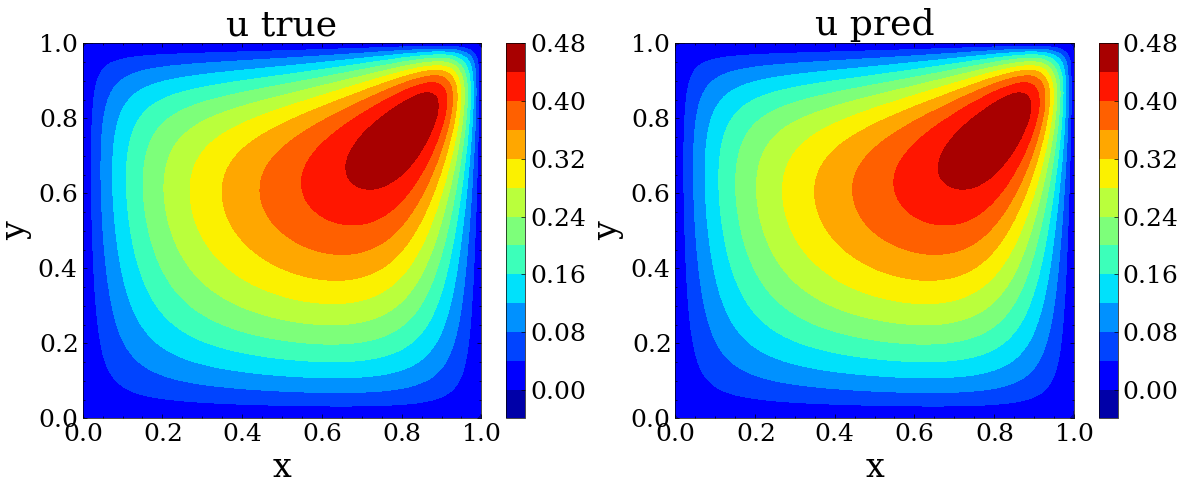

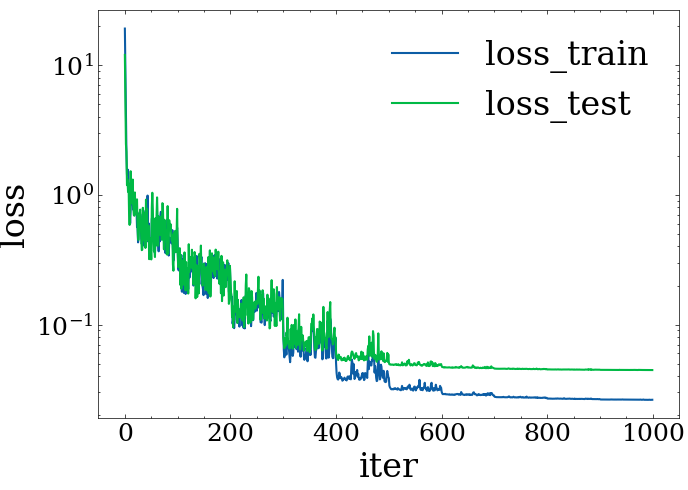

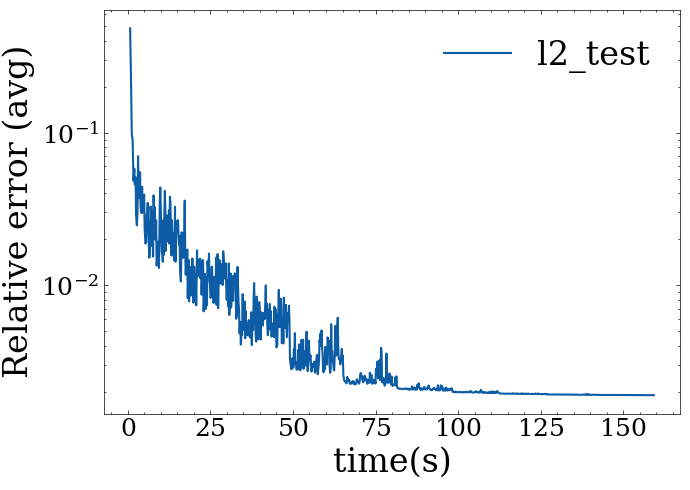

In [6]:
#####################################
# Load the trained model
#####################################
from Solvers.FNO import FNO
solver = FNO.Solver(device, dtype)
model_trained = solver.loadModel(path=f'saved_models/{netType}/', name='model_fno_final')

#########################################
with torch.no_grad():
    ax = normalizer_ax.encode(ax_test.to(device))
    u_pred = model_trained['u'](ax)
    u_pred = normalizer_u.decode(u_pred).detach().cpu()
#
u_pred = u_pred.reshape(u_pred.shape[0], -1, 1)
u_test = u_test.reshape(u_test.shape[0], -1, 1)
print('The shape of ax_norm:', ax.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of u_pred:', u_pred.shape)
print('The shape of meshgrid:', gridx_test.shape)
print('The test loss', solver.getLoss(u_pred, u_test))
print('The test l2 error:', solver.getError(u_pred, u_test))
print('*************************************')
for i in range(0, 5):
    print(f'The test l2 error for {i}:', solver.getError(u_pred[i:i+1], u_test[i:i+1]))
inx = 0
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(gridx_test, [u_test[0], u_pred[0]], ['u true', 'u pred'], lb=0.)
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/{netType}/', name='loss_fno')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test']], ['loss_train', 'loss_test'])
# show error
Plot.show_error([loss_saved['time']]*2, [loss_saved['l2_test']], ['l2_test'])